### Teori
(Her er alltid $j$ indeks for $x$, mens $k$ er ineks for energier)

Vi skal lage en algoritme som tar i et potensialet $V(x)$, hvor vi antatr $V(x) = \infty, x \in [-\infty, 0> \cup <L, \infty]$, mens det kan ha en virkårlig form i intervallet $I = [0, L>$. $I$ Diskretiseres opp i $n$ delintervaller, $\{I_j\}_{j = 1} ^ {n}$, med lengder på $\Delta x = L / (n + 1)$. Vi diskretiserer derreter potensialet ved å sette $V_j = V(\Delta x \cdot j), \, j = 1, 2, ... n$ og grensebetingelsene $V_0 = V_{n+1} = \infty$, slik at vi har en vektor ${\vec V} = [V_1, V_2, ... V_{n + 1}]$. Den tidsuavhengige Shrödingerligningen i 1D, TUSL, er gitt ved 

$$ \hat H \psi(x) =  \Big( \frac{-\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + \hat V\Big) \psi(x) = E \psi(x) $$

Vi diskretiserer $\psi(x)$ på samme måten, og lar $\psi_j = \psi(\Delta x \cdot j),\, \psi_0 = \psi_{n+1} = 0$ som gir vektoren $\vec \psi$. Hamiltonoperatoren tilnærmes med matrisen $\mathbb{H} = [H_{j, k}]$, som er tri-diagonal, slik at

$$
\mathbb{H}=
\begin{pmatrix}
    H_{1, 1} & H_{1, 2} & 0        & 0          & \dots      & 0            \\[1mm]
    H_{2, 1} & H_{2, 2} & H_{2, 3} & 0          & \dots      & \vdots       \\[1mm]
    0        & H_{3, 2} & \ddots   & \ddots     & 0          & 0            \\[1mm]
    0        & 0        & \ddots   & \ddots     & H_{n-1, n} & 0            \\[1mm]
    \vdots   & \vdots   & 0        & H_{n, n-1} & H_{n, n}   & H_{n, n+1}   \\[1mm]
    0        & \dots    & 0        & 0          & H_{n+1, n} & H_{n+1, n+1} \\[1mm]
 \end{pmatrix}
$$

hvor $H_{j, j} = \frac{\hbar^2}{m(\Delta x)^2} + V_j$, og $H_{j, j\pm 1} = \frac{-\hbar^2}{2m(\Delta x)^2}$. TUSL kan da aproskimeres som et egenverdiproblem,

$$ \mathbb{H} \vec \psi_k = E_k \vec \psi_k$$

Dette gir $n$ forskjellige egenverdier $E_j$, med tilhørende egenvektorer $\vec \psi_k = \psi_{j, k}$, hvor den  som er en aproksimasjon av egenfunksjonen til den . Derreter kan vi tidsutvikle en vilkårilg starttilstand $\Psi (x, 0)$. Denne starttilstanden aproksimeres som en superposisjonen av egenvektorene, 

$$\Psi_j = \sum_{k = 1}^{n} c_{k} \psi_{j, k} \exp(-i E_k t / \hbar),$$

eller med matrisenotasjon $\psi = [\psi_{j, k}], \, \vec c = [c_1, c_2, ... c_{n+1}]$ blir det $\vec \Psi(t) = \psi (\vec c \cdot \exp(i t / \hbar \vec E)) $. $\vec c$ finnes ved $c_j = \sum_{j = 1}^{n + 1} \psi_{j, k} \Psi_j$, eller $\vec c = \vec \Psi^T \psi$ 

**Notasjon**

$V(x) =$ `VKont(x)`  
$L =$ `L`  
$\Delta x$ = `deltaX`  
$n$ = `n`  
$\vec V$ = `V`  
$\mathbb{H} = $ `H[j][k]`  
$\psi = $ `psi[j][k]`  
$c = $ `c[k]`  
$\Psi(x, 0) = $ `f(x)`  
$\vec \Psi(t) = $ `Psi[j](t)`  

### Dimesjonsløshet

Sånn Shcrödingerlingingen står nå, vår man veldig små tall i bergeningene. Dette kan føre til flyttallfeil. VVi innfører derfor de dimesjonsløse størrelsene $ q = x / L $, $ \epsilon = E / (\hbar^2 / 2mL^2) $ og $ \hat \nu = \hat V / (\hbar^2 / 2mL^2) $. Siden

$$ \frac{\partial^2}{\partial q^2} \psi(q) = \Big( \frac{\partial x}{\partial q} \frac{\partial}{\partial x} \Big)^2 \psi(x)= L^2 \frac{\partial^2}{\partial x^2} \psi(x), $$

kan vi ved å multiplisere med $2mL^2 / \hbar^2 $ på begge sider av Schrödingerligningen skrive den om til

$$ \Big(-\frac{\partial^2}{\partial q^2} + \hat \nu \Big) \psi = \epsilon \psi.$$

Dette gjør at de nye elementene i $ \mathbb{H} $ matrisen blir $ H_{j, j} = 2 / (\Delta x)^2 + \hat \nu$ og $ H_{j, j \pm 1} = - 1 / (\Delta x)^2 $

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import numpy as np
from numpy import pi


L = 100
n = 1000
inf = 1e10        # Alle vet at uendelig er ca 10 milliarder
deltaq = 1 / (n + 1)


def solveTUSL(V, n):
    
    # Hjj are diagonal values, HOD are of the diagonal
    Hjj = 2 / deltaq**2* np.ones(n) + V[1:-1]
    HOD= -1 / deltaq**2 * np.ones(n - 1)
    return la.eigh_tridiagonal(Hjj, HOD)

def plotEigenfunc(phi, V, x, l, epsilonRange=0):
    
    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25}
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    mpl.rc('font', **font)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))

    # Inneholder Line2D elementer som viser legend hvordan linja ser ut
    legendElement = [0] * (l + 1)
    legendElement[0], = ax1.plot(x, V, color="Black", label="$V_0$")
    ax1.set_label("E")
    ax1.set_xlabel("$q$")
    ax1.set_ylabel("$\epsilon $")
    labels =  [0] * (l + 1)
    labels[0] = "$ \\nu (q)$"
    ax2 = ax1.twinx()
    ax2.set_ylabel("$\psi$")

    for i in range(l):
        legendElement[1 + i],  = ax2.plot(x[1: -1], phi[:, i])
        labels[1+ i] = "$\epsilon_" + str(i + 1) + "$"
    
    if not epsilonRange:
        ax1.set_ylim(np.min(V[1:-1])*1.2, np.max(V[1:-1])*1.2)
    else:
         ax1.set_ylim(*epsilonRange)
    
    ax2.set_ylim(np.min(phi)*1.2, np.max(phi)*1.2)
    ax2.legend(legendElement[:][:l + 1], labels[:l + 1], fontsize=20)
    
    plt.show()

## Oppgave 1: Partikkel i boks

1) Sjekk om svar stemmer med de analytiske løsningene  
2) Sjekk om løsningene er ortonormerte  
3) Sjekk om det er et fullstendig sett


(Gjør det mulig å tidsuvikle en sartposisjon?)  
(Lag finer plott?)

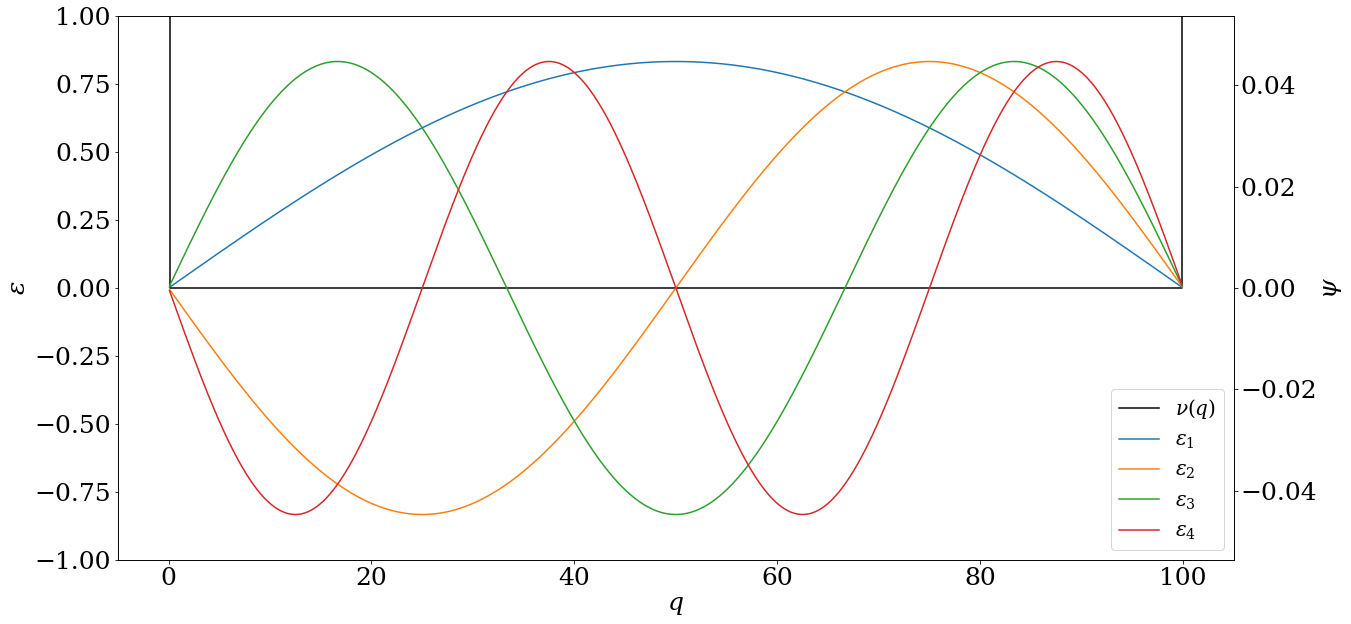

In [2]:
x_1 = np.linspace(0, L, n + 2)
V_1 = np.zeros(n + 2)
V_1[0], V_1[-1] = inf, inf

def EExact(j):
    return ((j + 1) * pi)**2

E_1, phi_1 = solveTUSL(V_1, n)
l_1 = 4

plotEigenfunc(phi_1, V_1, x_1, l_1, (-1, 1))

### Energiegenverdier

Den analytiske løsningen for energien til en partikkel i boks er 

$$ \epsilon_k = \frac{mL^2}{\hbar^2} E_k = k^2 \pi^2. $$

Under printes både numeriske og analytisk beregnet dimensjonsløs energi, og man kan tydlig se at de stemmer godt overens.

In [3]:
precision = 6
tableWidth = 15

print("Energies:")
print("Numerisk:".ljust(tableWidth), "Analytisk:".ljust(tableWidth), "Relativ feil:".ljust(tableWidth))

for i in range(l_1):
    print(("{:.{prec}e}").format(E_1[i], prec=precision).ljust(tableWidth),\
          ("{:.{prec}e}").format(EExact(i), prec=precision).ljust(tableWidth),\
          ("{:.{prec}e}").format((EExact(i) - E_1[i]) / EExact(i), prec=precision).ljust(tableWidth))

Energies:
Numerisk:       Analytisk:      Relativ feil:  
9.869596e+00    9.869604e+00    8.207916e-07   
3.947829e+01    3.947842e+01    3.283289e-06   
8.882578e+01    8.882644e+01    7.387394e-06   
1.579116e+02    1.579137e+02    1.313312e-05   


### Ortonormalitet

Vi kan se her at opp til en feil av størrelsesorden $10^{-10}$ er vektorene $ \vec \Psi_k $ ortonormale, altså er $\vec \Psi_i \cdot \vec \Psi_j = \delta_{i, j}$, eller at $\Psi_{j, k} \cdot \Psi_{j, k}^T = \mathbb{I}$, identitetsmatrisen, som sjekkes i koden under.

In [4]:
np.set_printoptions(precision=2)

p = phi_1 @ phi_1.T
print(p)

# Sjekker om diagonalen er nær 1, og resten nær 0


tol = 10e-10
i = 0

while(i < len(p[0]) and p[i, i] - 1 < tol and np.sum(abs(p[i,:i:])) < tol):
    i += 1
    
print("\nFeil innenfor toleransen: ", i == len(p))

[[ 1.00e+00  2.50e-16 -3.33e-16 ...  1.38e-16  1.78e-16  8.51e-17]
 [ 2.50e-16  1.00e+00 -1.44e-15 ... -3.15e-16  5.33e-17  5.45e-16]
 [-3.33e-16 -1.44e-15  1.00e+00 ...  6.84e-17 -4.25e-16 -2.15e-16]
 ...
 [ 1.38e-16 -3.15e-16  6.84e-17 ...  1.00e+00 -8.88e-16  1.03e-15]
 [ 1.78e-16  5.33e-17 -4.25e-16 ... -8.88e-16  1.00e+00  2.11e-15]
 [ 8.51e-17  5.45e-16 -2.15e-16 ...  1.03e-15  2.11e-15  1.00e+00]]

Feil innenfor toleransen:  True


## Oppgave 2: Atomer

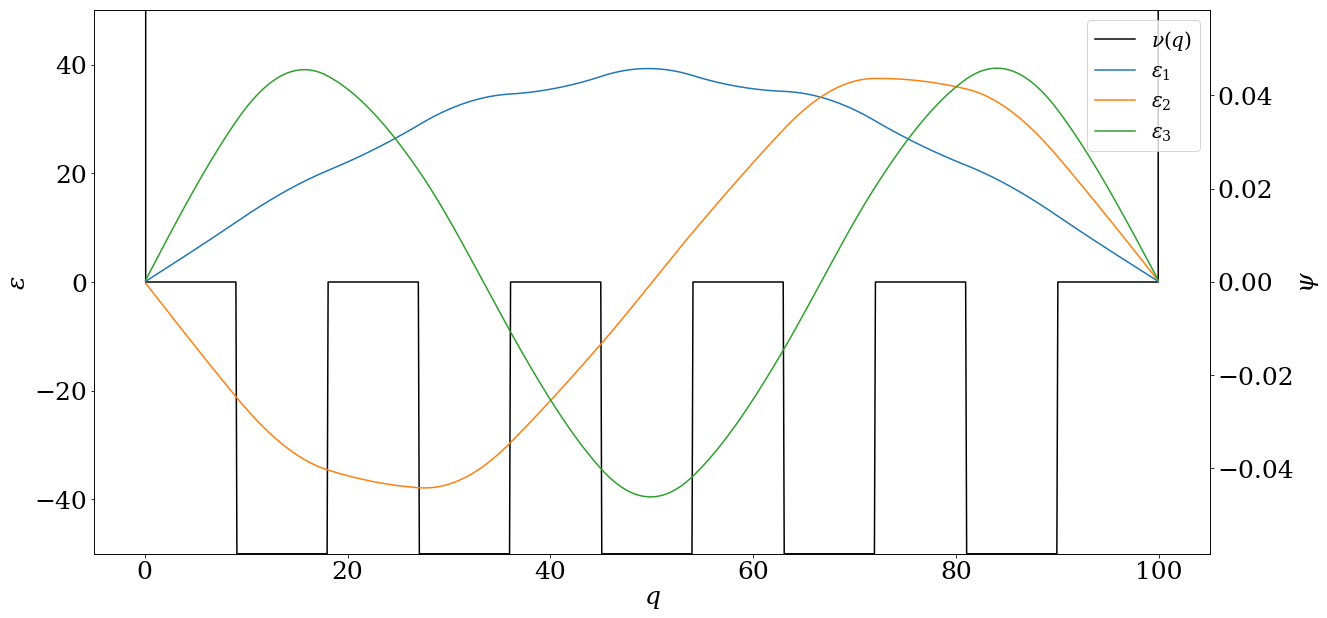

-15.623753768429891
13.736310673549049
62.522537051053604


In [5]:
V0_2 = -50
x_2 = np.linspace(0, L, n + 2)
w_2 = 5
V_2 = np.ones(1) * inf
for i in range(w_2):
    V_2 = np.concatenate((V_2, np.zeros(n // (2*w_2 + 1)), V0_2 * np.ones(n // (2*w_2 + 1))))
    

V_2 = np.concatenate((V_2, np.zeros(n // (2*w_2 + 1) + n % (2*w_2 + 1)), np.ones(1) * inf))

E_2, phi_2 = solveTUSL(V_2, n)
l_2 = 3
plotEigenfunc(phi_2, V_2, x_2, l_2, (V0_2, -V0_2))

for i in range(l_2):
    print(E_2[i] - V_2[1:-1][i])

## Oppgave 3: Molekyler

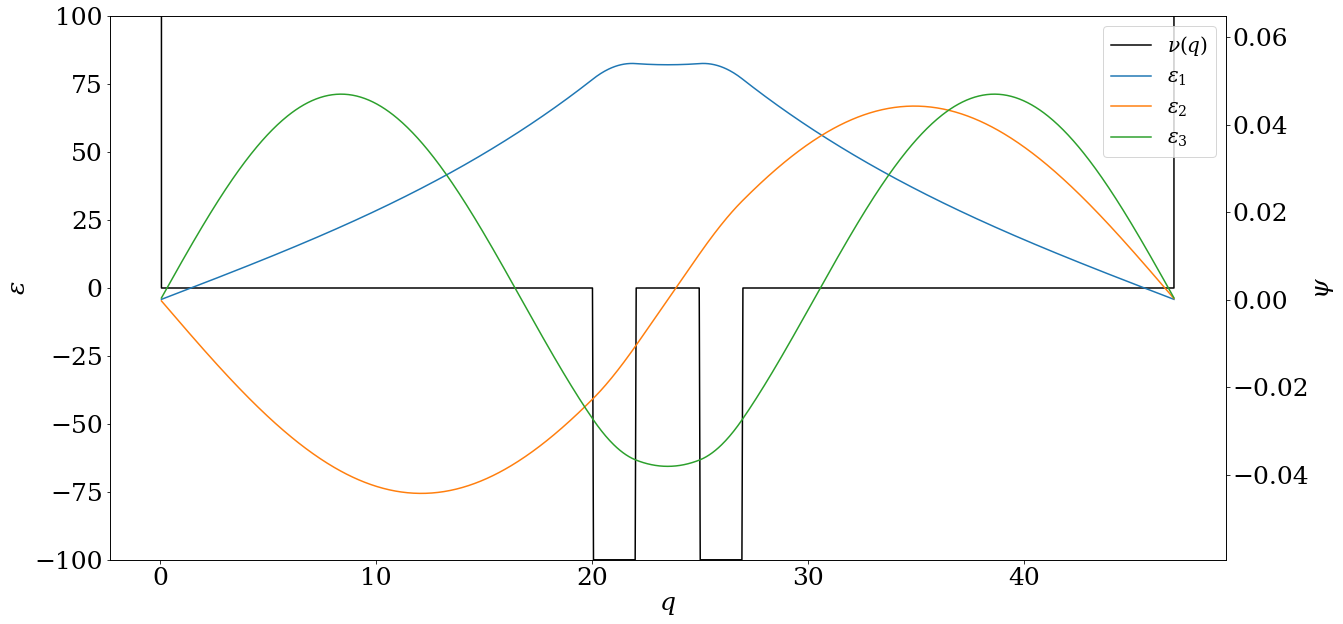

-10.007835255803492
37.561725284229865
78.33408235586936


In [6]:
V0_3 = -100
w_3 = 2
b_3 = 3

V_3 = np.ones(1) * inf
V_3 = np.concatenate((V_3, np.zeros(n * 10 * w_3 // int(22 * w_3 + b_3))))
V_3 = np.concatenate((V_3, V0_3 * np.ones(n * w_3 // (22 * w_3 + b_3))))
V_3 = np.concatenate((V_3, np.zeros(n * b_3 // (22 * w_3 + b_3))))
V_3 = np.concatenate((V_3, V0_3 * np.ones(n * w_3 // (22*w_3 + b_3))))
V_3 = np.concatenate((V_3, np.zeros(n*int(10 * w_3) // (22 * w_3 + b_3))))
V_3 = np.concatenate((V_3, np.ones(1) * inf))

n_3 = len(V_3)
x_3 = np.linspace(0, (22 * w_3 + b_3), n_3)
E_3, phi_3 = solveTUSL(V_3, n_3-2)
l_3 = 3
plotEigenfunc(phi_3, V_3, x_3, l_3, (V0_3, -V0_3))

for i in range(l_3):
    print(E_3[i])

## Oppgave 4: Krystaller

## Bonus: Tidsutvikling

## Lekestua

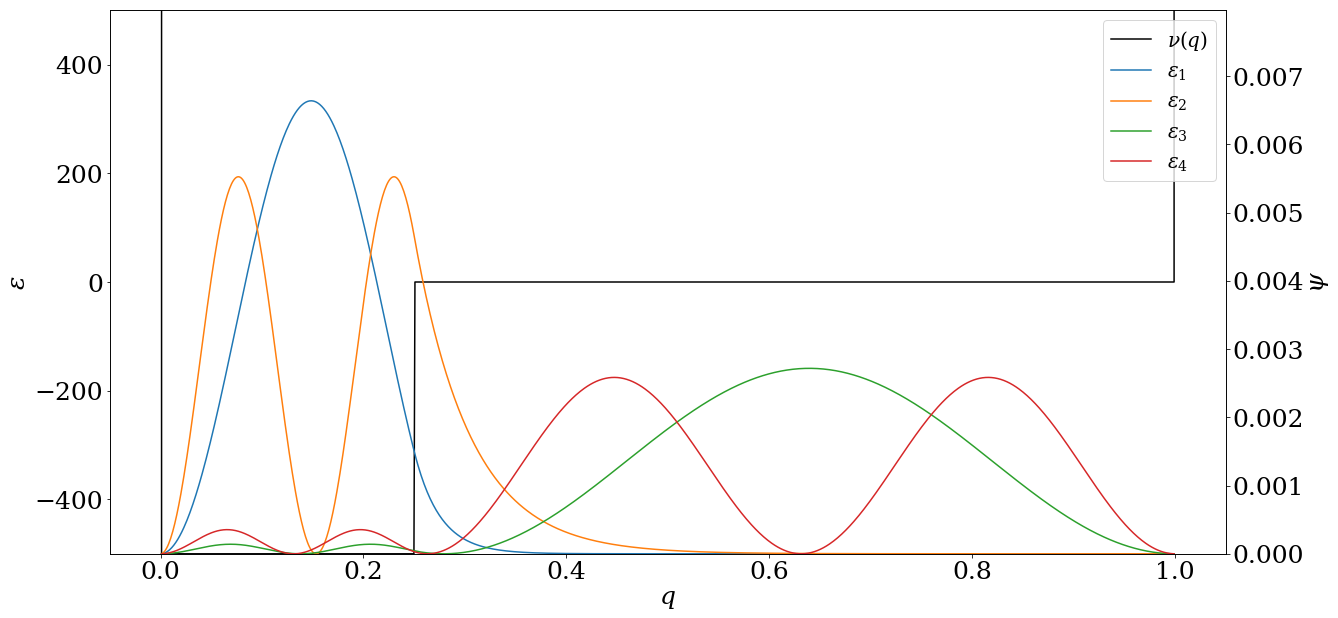

112.00999640685609
419.4565781495905
518.9850187602311
572.6566290345047


In [25]:
def VExact(x):
    return 1 / (x + 0.5)

x = np.linspace(0, 1, n + 2)
VL = VExact(x)
V0L = -500
VL = np.concatenate(([inf], np.ones(n // 4)*V0L, np.zeros(n - n // 4), [inf]))

EL, phiL = solveTUSL(VL, n)

l = 4
plotEigenfunc(phiL**2, VL, x, l, (V0L, -V0L))
for i in range(l):
    print(EL[i] - VL[1:-1][i])